In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Blending Images(rainbow_oil_spill)+sea


# Data_Preparation

In [ ]:
import os
from PIL import Image
count=64
img=cv2.imread("../Computer Vision/OSRL/Dataset/clear_sea/clear_sea9.jpg")
filepath="../Computer Vision/OSRL/Dataset/spill/"
for filename in os.listdir("../Computer Vision/OSRL/Dataset/spill/"):
  imgpath=filepath+filename
  spill = cv2.imread(imgpath)
  img=cv2.resize(img,(480, 320))
  spillimg=cv2.resize(spill,(480, 320))
  #cv2_imshow(img)
  cv2_imshow(spillimg)
  blend = cv2.addWeighted(img, 0.95, spillimg, 0.5, 0.0)
  cv2_imshow(blend)
  print(img.shape)
  filename="train_spill ("+str(count)+").jpg"
  count=count+1
  savepath="../Computer Vision/OSRL/Dataset/oil_spill_reshape/"+filename
  cv2.imwrite(savepath,blend)

#spill.shape

In [ ]:
filepath="../Computer Vision/OSRL/Dataset/oil_spill/"
for filename in os.listdir("../Computer Vision/OSRL/Dataset/oil_spill/"):
  imgpath=filepath+filename
  img=cv2.imread(imgpath)
  img=cv2.resize(img,(480, 320))
  savepath="../Computer Vision/OSRL/Dataset/oil_spill_reshape/"+filename
  cv2.imwrite(savepath,img)

Getting mask of test images

In [ ]:
import json
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from skimage import img_as_bool
from skimage.transform import resize


f = open('../Computer Vision/OSRL/Dataset/Dataset_Added/test/via_project_2Feb2021_7h26m_json.json')
data = json.load(f) 

img_dir = '../content/drive/Shareddrives/groundup.ai AI Projects/Computer Vision/OSRL/Dataset/Dataset_Added/test/images/' #where images are placed

for key,value in enumerate(data):
  #print("Imagename: ", data[value]['filename'])

  imgpath = os.path.join(img_dir,data[value]['filename'])
  img = cv2.imread(imgpath)
  #print(img.shape)
  #mask = np.zeros(img.shape[:2])
  mask = Image.new('L', (img.shape[1], img.shape[0]), 0)
  for subset_dict in data[value]['regions']:
    #print(img.shape)
    xpoints = subset_dict["shape_attributes"]["all_points_x"]
    ypoints = subset_dict["shape_attributes"]["all_points_y"]
    polygon = list(zip(xpoints, ypoints))
    
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
  

  # mask = mask.resize((480, 320), Image.ANTIALIAS)
  # print(mask.size)
  finalmask = np.array(mask)
  print(finalmask.shape)
  #finalmask=resize(finalmask, (480, 320))
  #im = Image.fromarray(finalmask)
  # finalmask = img_as_bool(resize(finalmask, (320,480)))
  
  # print(finalmask.shape)
  img_name=data[value]['filename']
  print(img_name)
  imgname1 = img_name.split('.jpg')[0]
  ##print(imgname1)
  pathname='../Computer Vision/OSRL/Dataset/Dataset_Added/test/mask/'+imgname1+'.npy'
  #im.save(pathname)
  np.save(pathname,finalmask)
  
  
  



In [3]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1

     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 3.9MB 13.4MB/s 
     |████████████████████████████████| 450kB 52.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=2ddda0e31f1f94ca1a41e3c1f2fdbbeacd130312bb2b50187102c55ce914a9b0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'wirerope']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        #print(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        mask_ids=[]
        for image_id in self.ids:
          img_name=image_id

          img_name=img_name.split('.jpg')[0]+".npy"
          #print(img_name)
          mask_ids.append(img_name)
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]
        #print(self.masks_fps)
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        #print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(self.masks_fps[i])
        
        mask = np.load(self.masks_fps[i])
        # print(mask.shape)
        #mask= np.expand_dims(mask, axis =-1) 
        #mask=np.transpose(mask, (1, 2, 0))
        #mask = mask.astype(np.bool)
        #print(mask.shape)
        # print(type(mask))
        #print(self.class_values)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        
        mask = np.stack(masks, axis=-1).astype('float')
        #print(mask.size)
        # print(mask.shape[-1])
        # # add background if mask is not binary
        # if mask.shape[-1] != 1:
        #     background = 1 - mask.sum(axis=-1, keepdims=True)
        #     mask = np.concatenate((mask, background), axis=-1)
        
        # # apply augmentations
        # if self.augmentation:
        #     sample = self.augmentation(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        # if self.preprocessing:
        #     sample = self.preprocessing(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


(320, 480, 3)
(320, 480, 1)


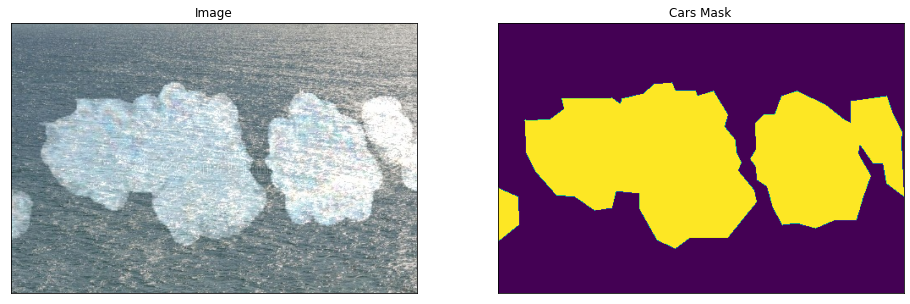

In [ ]:
x_train_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/train/images"
y_train_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/train/mask"
dataset = Dataset(x_train_dir, y_train_dir, classes=['wirerope'])

image, mask = dataset[71] # get some sample
print(image.shape)
#print(mask[..., 2].squeeze())

print(mask.shape)
visualize(
    image=image, 
    cars_mask=mask[...,0].squeeze(),
)

# Data Augumentation

In [ ]:
### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

In [ ]:
import albumentations as A

In [ ]:
original_height,original_width =320,480
aug1 = A.PadIfNeeded(min_height=128, min_width=128, p=1)
aug2 = A.HorizontalFlip(p=1)
aug3 = A.IAAAdditiveGaussianNoise(p=0.2),
aug4 = A.VerticalFlip(p=1)
#aug5 = A.RandomRotate90(p=1)
#aug6 = A.Transpose(p=1)
aug5 = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
aug6 = A.GridDistortion(p=1)
aug7 = A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
# aug10 = A.Compose([
#     A.OneOf([
#         A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
#         A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
#     ], p=1),    
#     A.VerticalFlip(p=0.5),              
#     A.RandomRotate90(p=0.5),
#     A.OneOf([
#         A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#         A.GridDistortion(p=0.5),
#         A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
#         ], p=0.8),
#     A.CLAHE(p=0.8),
#     A.RandomBrightnessContrast(p=0.8),    
#     A.RandomGamma(p=0.8)],
#     )

In [ ]:
 import matplotlib.pyplot as plt
 import os
 import numpy as np
 import cv2
 count=0
 path="../Computer Vision/OSRL/Dataset/Dataset_Added/val/images/"
 mask_path="../Computer Vision/OSRL/Dataset/Dataset_Added/val/mask/"
 for file in os.listdir('../Computer Vision/OSRL/Dataset/Dataset_Added/val/images/'):

   if file.endswith(".jpg"):

      image=cv2.imread((os.path.join(path, file)))
      name=mask_path+file.split('.jpg')[0]+".npy"
      mask = np.load(name)
      #mask=cv2.imread(os.path.join(mask_path, name)) 
      # print(file)
      # print(image.shape)
     
      # print(mask.shape)
      # #print(transform_list1)
    
      # plt.show()
      augmented = aug1(image=image, mask=mask)
      #print(augmented)
      image_padded = augmented['image']
      # if not (image_padded.shape[0] == 512 and image_padded.shape[1] == 512):
      #   image_padded = cv2.resize(image_padded,(512,512))
     
      mask_padded = augmented['mask']
      print(mask_padded.shape)
      mask = np.array(mask_padded )
      #im2  = Image.fromarray(np.uint8(mask_padded))
      # if not (mask_padded.shape[0]==512 and mask_padded.shape[1]==512):
      #   im2 = im2.resize((512,512),resample=0)
      print(image_padded.shape)
      #print(mask_padded)
      #visualize(image_padded, mask_padded, original_image=image, original_mask=mask)
      count=count+1
      filename="aug1_"+str(count)+".jpg"
      filemask="../Computer Vision/OSRL/Dataset/Dataset_Added/val/maskaug/"+"aug1_"+str(count)+".npy"
      cv2.imwrite(os.path.join("../Computer Vision/OSRL/Dataset/Dataset_Added/val/imgaug/",filename),image_padded)
      
      np.save(filemask,mask_padded)

In [6]:
!pip install git+https://github.com/qubvel/segmentation_models
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-28nnw51l
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-28nnw51l
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=351824bcd04abd805b88402300b0e8385adaf58dce906786a275c4986b628d9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-lwa_kkng/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [13]:
import segmentation_models as sm

In [14]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['wirerope']
LR = 0.0001
EPOCHS = 25
preprocess_input = sm.get_preprocessing(BACKBONE)

In [21]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model= sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [26]:
# define optomizer
import keras
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
total_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [18]:
x_train_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/train/imgaug"
y_train_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/train/maskaug"
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=None,
)
x_valid_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/val/imgaug"
y_valid_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/val/maskaug"

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=None,
)

train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 480, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 480, n_classes)

# assert valid_dataloader[0][0].shape == (BATCH_SIZE, 320, 480, 3)
# assert valid_dataloader[0][1].shape == (BATCH_SIZE, 320, 480, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('../Computer Vision/OSRL/Models/best_model_FPNnet.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [19]:
print(len(train_dataloader))
print(len(valid_dataloader))

60
60


In [ ]:
# history = model.fit_generator(
#     train_dataloader, 
#     steps_per_epoch=len(train_dataloader), 
#     epochs=EPOCHS, 
#     callbacks=callbacks, 
#     validation_data=valid_dataloader, 
#     validation_steps=len(valid_dataloader),
# )

In [24]:
# x_test_dir="/content/drive/My Drive/wirerope/semantic/test/images/"
# y_test_dir="/content/drive/My Drive/wirerope/semantic/test/maskresize/"
x_test_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/test/images/"
y_test_dir="../Computer Vision/OSRL/Dataset/Dataset_Added/test/mask/"
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=None,
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# Loading the Model

In [22]:
model.load_weights('/content/drive/Shareddrives/groundup.ai AI Projects/Computer Vision/OSRL/Models/best_model.h5')

In [27]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.0078598
mean iou_score: 0.79893
mean f1-score: 0.86339


18


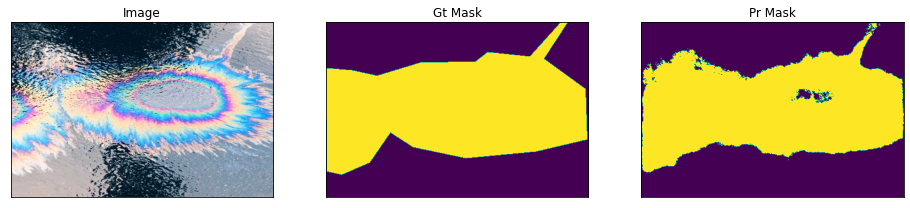

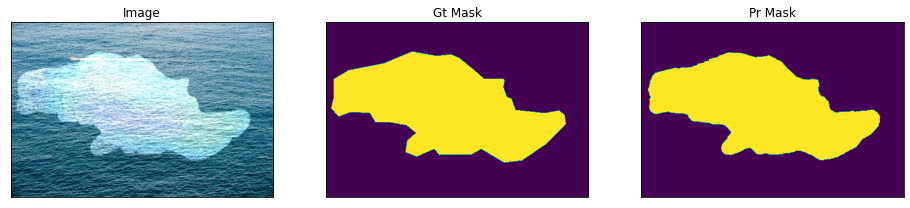

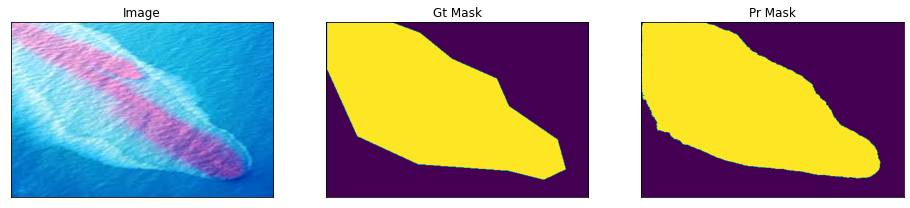

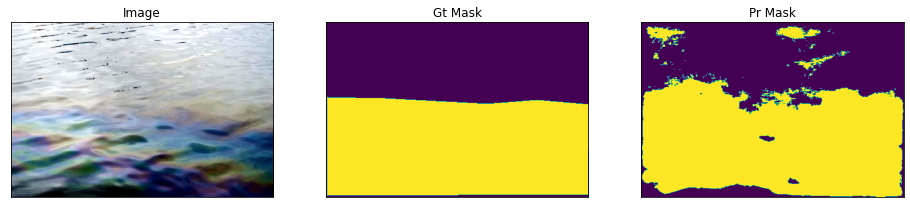

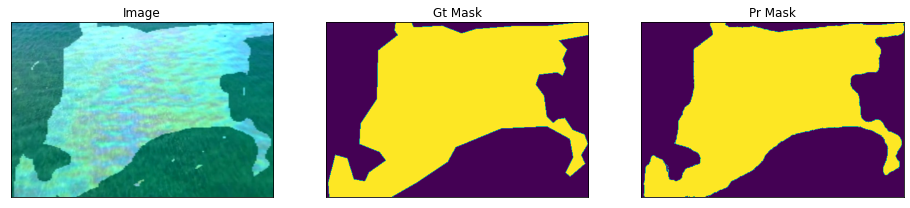

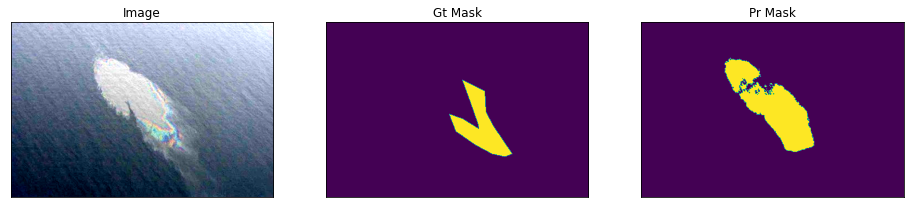

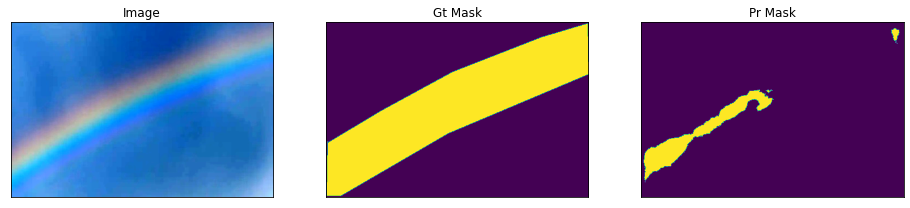

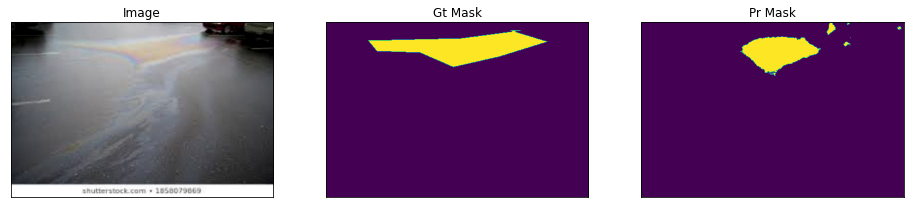

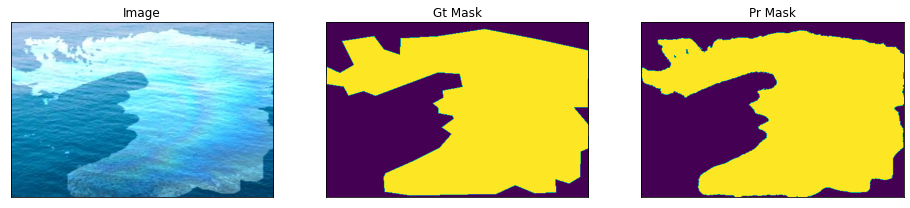

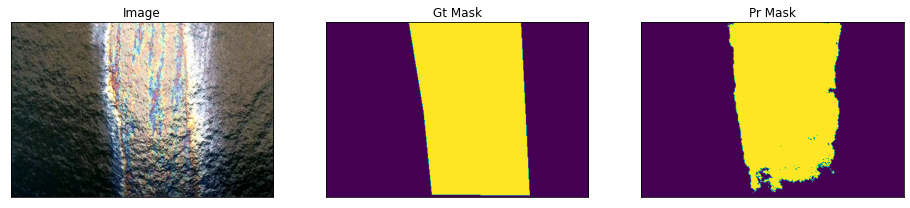

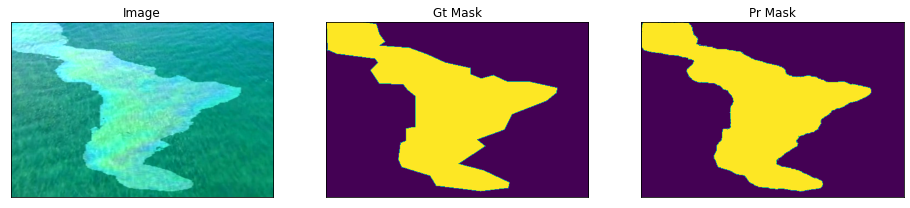

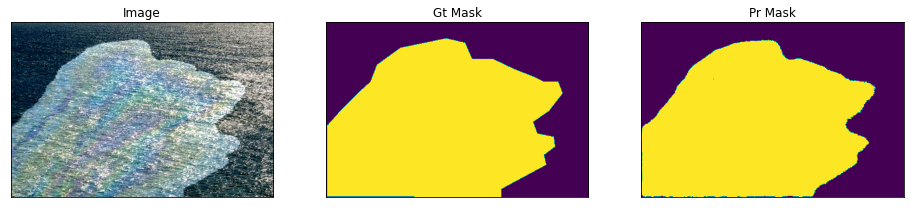

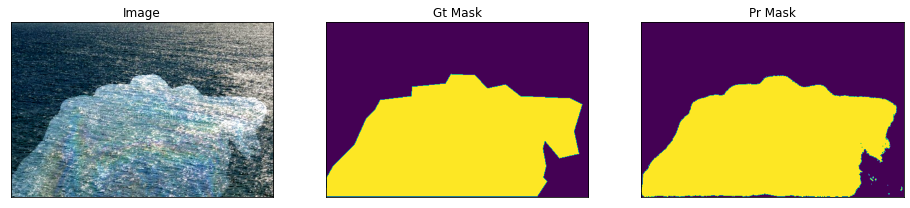

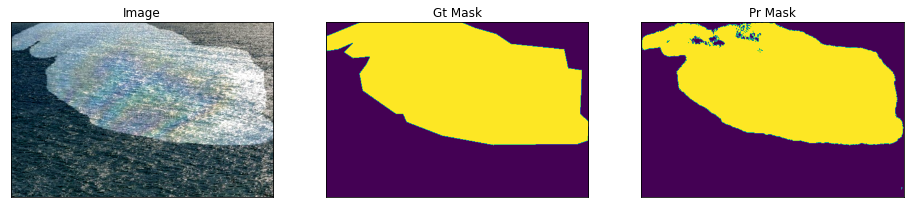

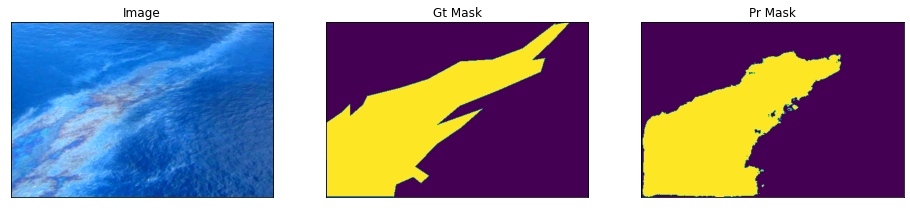

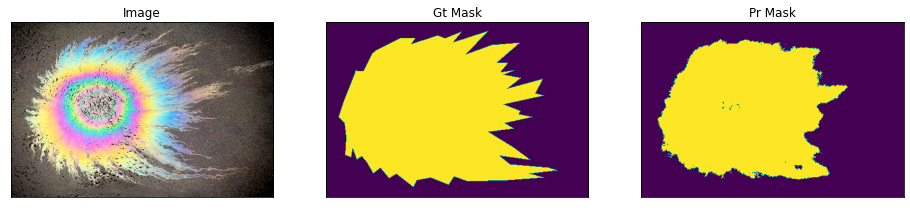

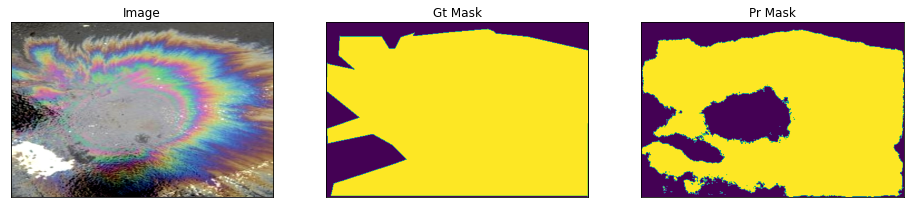

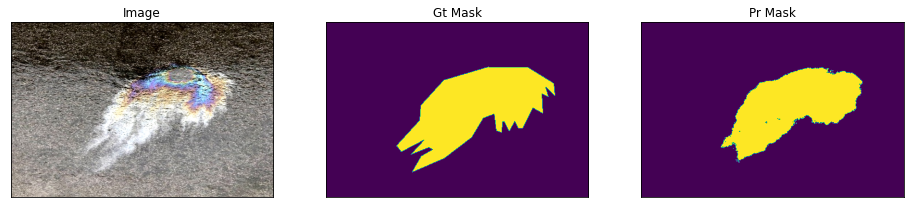

In [28]:
n = 20
ids = np.arange(len(test_dataset))
print(len(test_dataset))
#print(len(ids))
for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [29]:
# for boundary region
def crosslines(mask1,img):
    #global orig_img
    line_img = mask1.copy()
    h,w = line_img.shape[:2]
    
    for i in range(0,w-30,15):
        start_point = (i,0)
        end_point = (w,h-i)
        image = cv2.line(line_img, start_point, end_point, color=(0,0,0), thickness=2)
    
    for i in range(0,h-30,15):
        start_point = (0,i)
        end_point = (w-i,h)
        image = cv2.line(line_img, start_point, end_point, color=(0,0,0), thickness=2)
    
    cv2_imshow(image)
    #plt.imshow(image)
    return_img = img.copy()
    print(np.unique(mask1))
    return_img = cv2.bitwise_or(image, img)
    #return_img  =cv2.bitwise_or(return_img,img)
    #return_img[image==0] = img[image==0]
    cv2_imshow(return_img)
    return return_img

In [30]:
def crosslines(mask1,img):
  
    line_img = img.copy()
    h,w = line_img.shape[:2]
    
    for i in range(0,w-30,25):
        
        #print(i)
        start_point = (i,0)
        end_point = (w,h-i)
        image = cv2.line(line_img, start_point, end_point, color=(0,255,255), thickness=2)
    for i in range(0,h-30,25):
        
        start_point = (0,i)
        end_point = (w-i,h)
        image = cv2.line(line_img, start_point, end_point, color=(0,255,255), thickness=2)
    
    #plt.imshow(image)
    return_img = img.copy()
    print(np.unique(mask1))
    return_img[mask1==1] = image[mask1==1]
    
    return return_img



# Results

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
(320, 480)
float32
[0 1]
81309
153600
52.93554687499999


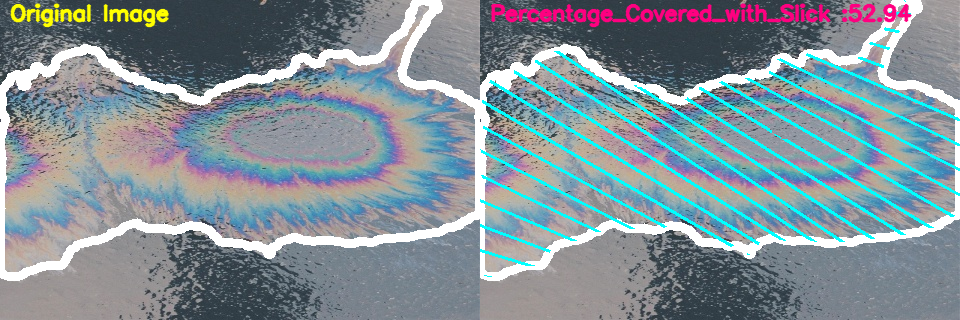

(320, 480)
float32
[0 1]
51718
153600
33.67057291666667


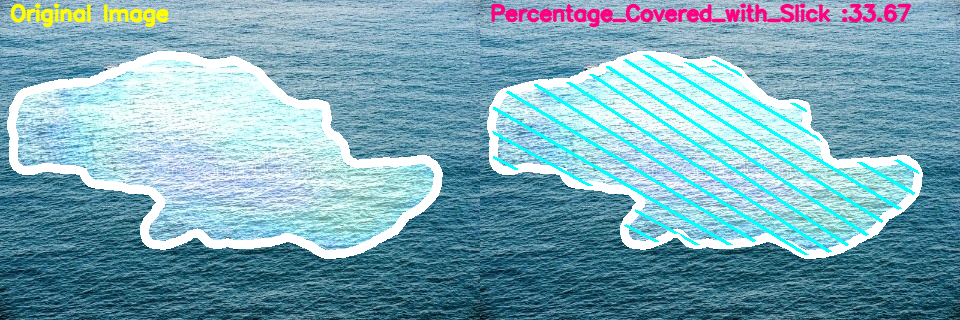

(320, 480)
float32
[0 1]
78500
153600
51.106770833333336


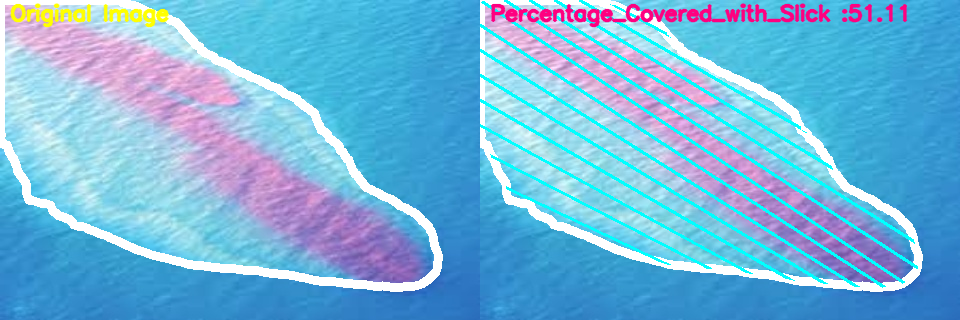

(320, 480)
float32
[0 1]
98165
153600
63.90950520833333


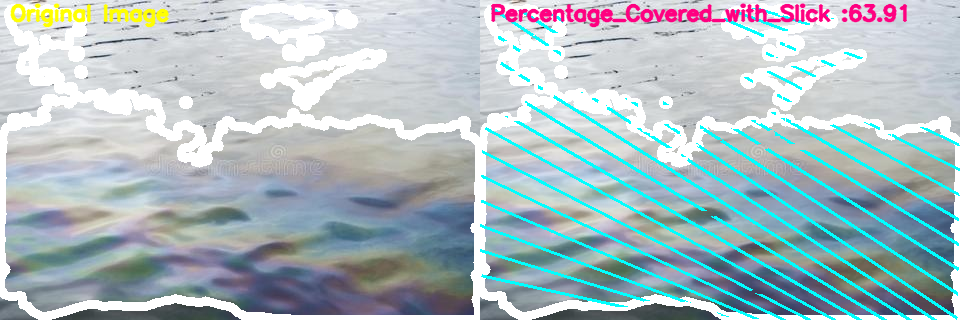

(320, 480)
float32
[0 1]
86641
153600
56.40690104166667


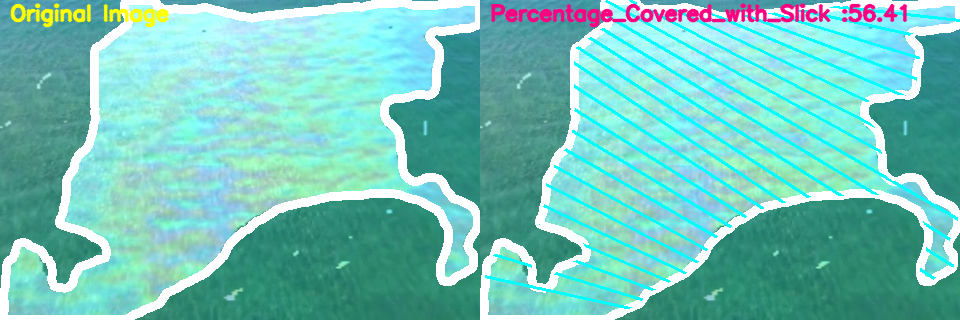

(320, 480)
float32
[0 1]
13369
153600
8.703776041666666


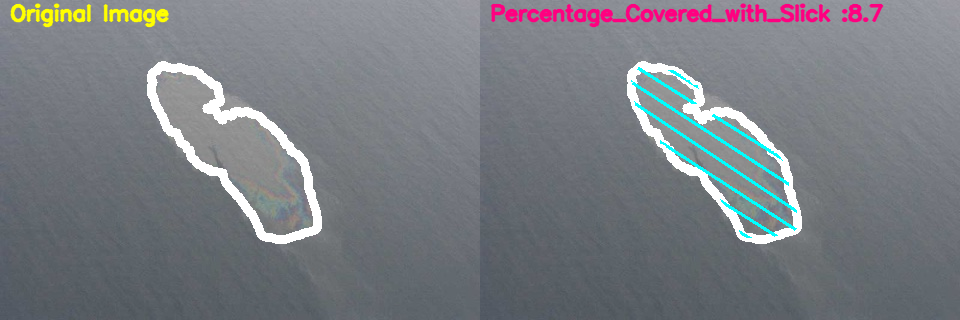

(320, 480)
float32
[0 1]
9152
153600
5.958333333333334


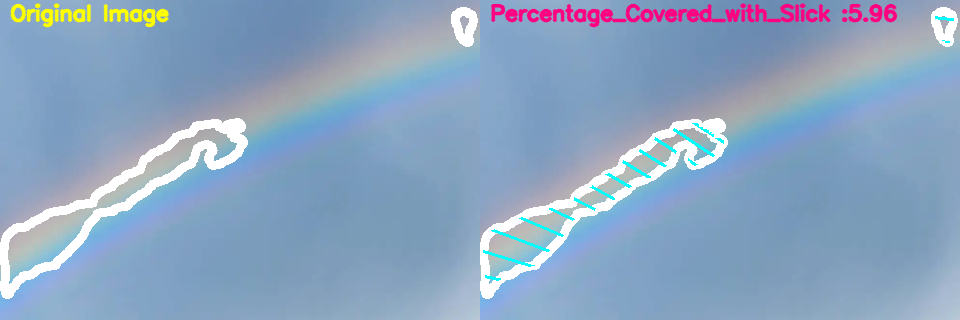

(320, 480)
float32
[0 1]
7588
153600
4.940104166666667


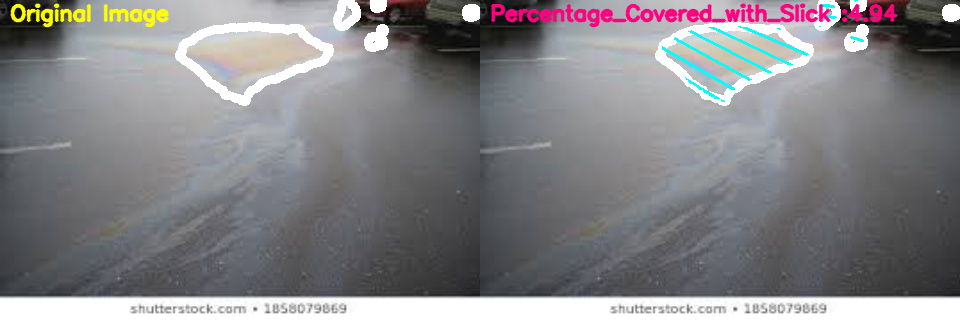

(320, 480)
float32
[0 1]
97246
153600
63.311197916666664


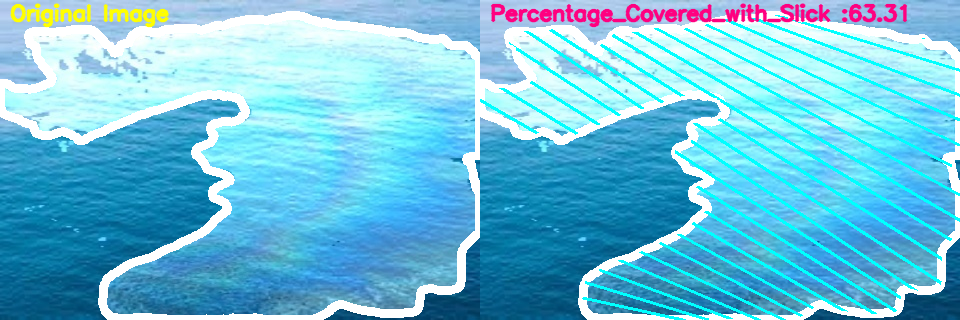

(320, 480)
float32
[0 1]
54617
153600
35.557942708333336


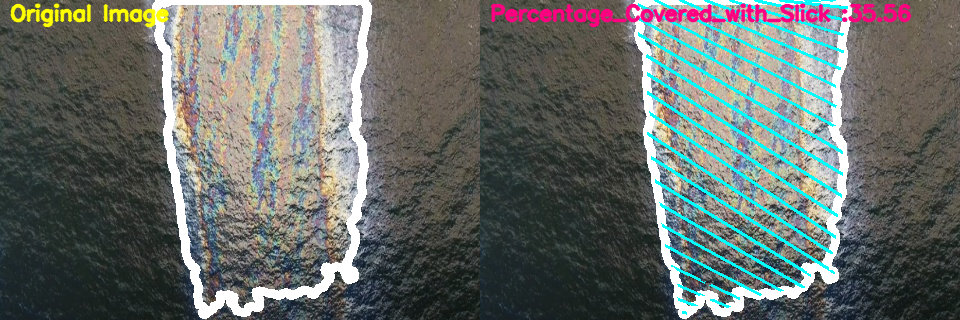

(320, 480)
float32
[0 1]
50938
153600
33.162760416666664


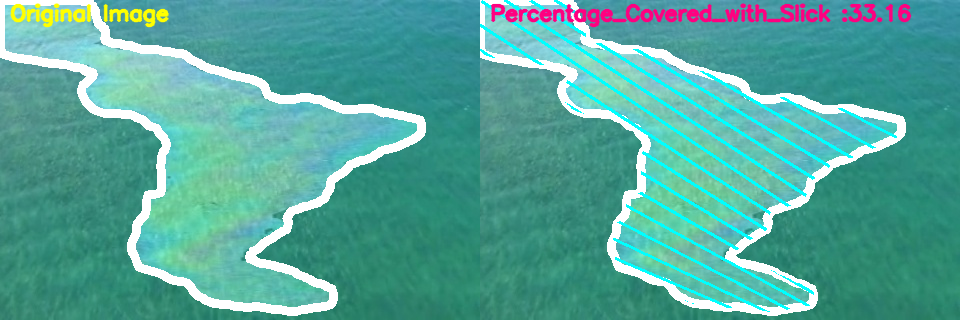

(320, 480)
float32
[0 1]
94017
153600
61.208984375


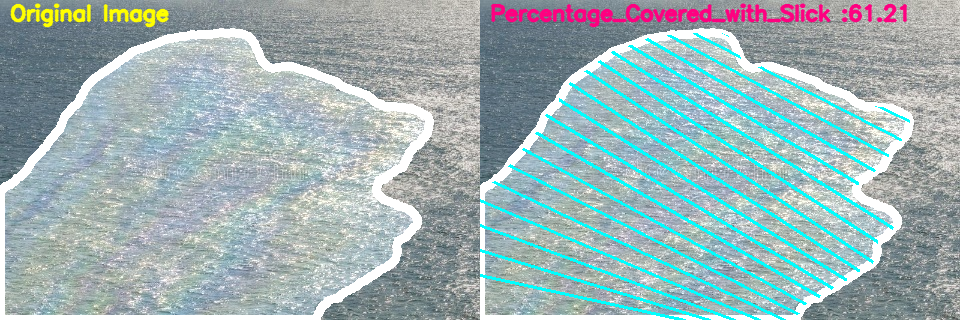

(320, 480)
float32
[0 1]
77940
153600
50.7421875


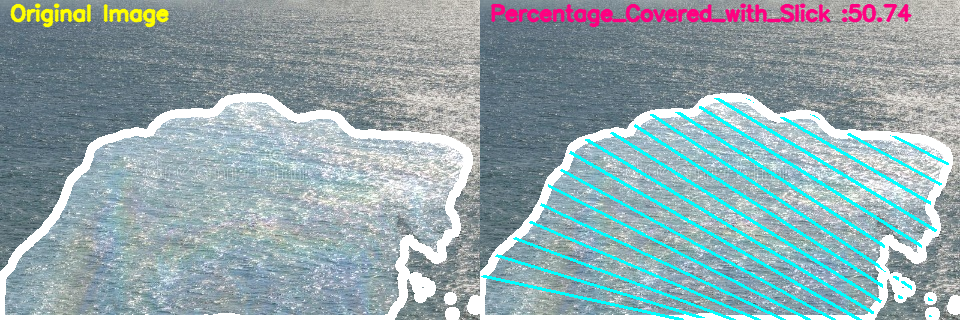

(320, 480)
float32
[0 1]
75576
153600
49.203125


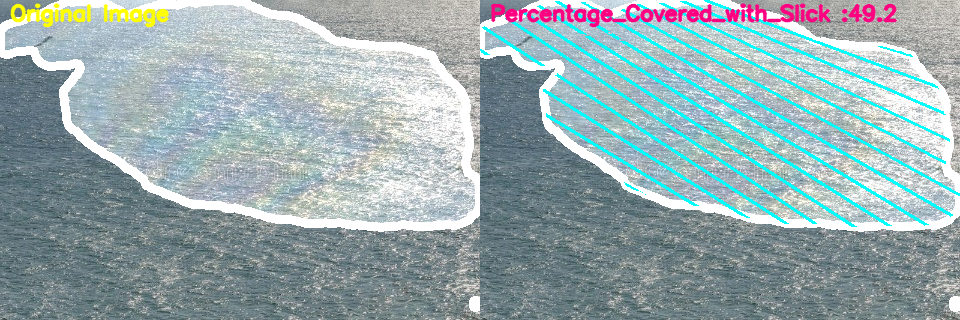

(320, 480)
float32
[0 1]
52194
153600
33.98046875


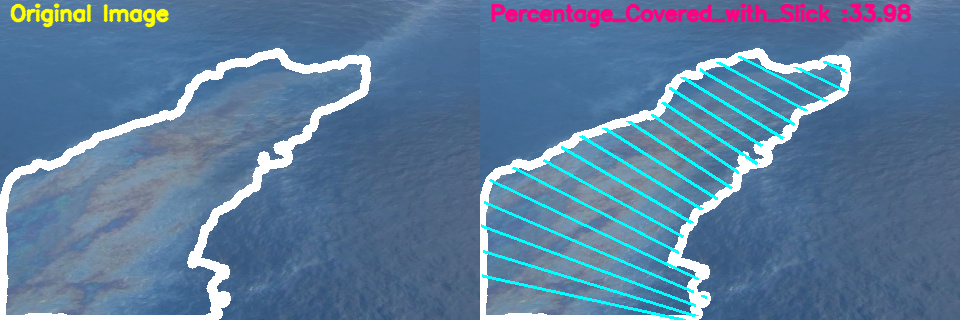

(320, 480)
float32
[0 1]
67097
153600
43.682942708333336


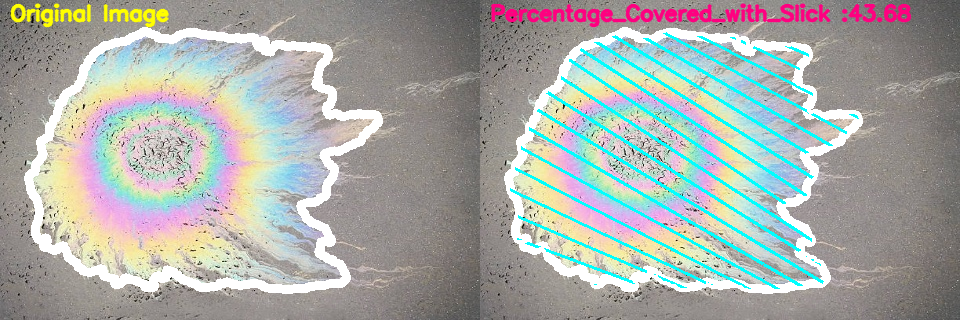

(320, 480)
float32
[0 1]
115400
153600
75.13020833333334


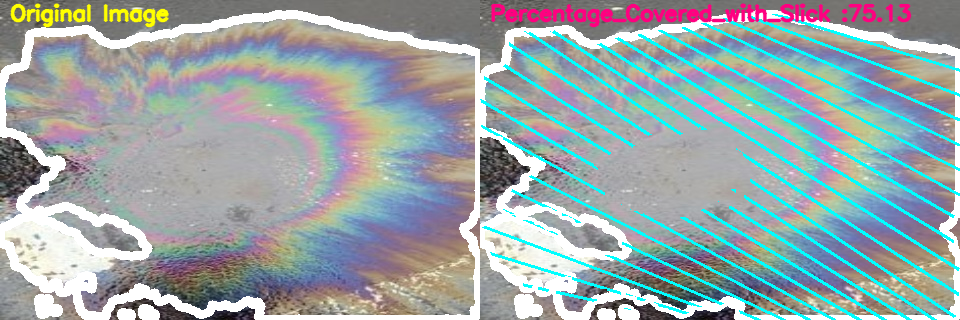

(320, 480)
float32
[0 1]
24731
153600
16.100911458333332


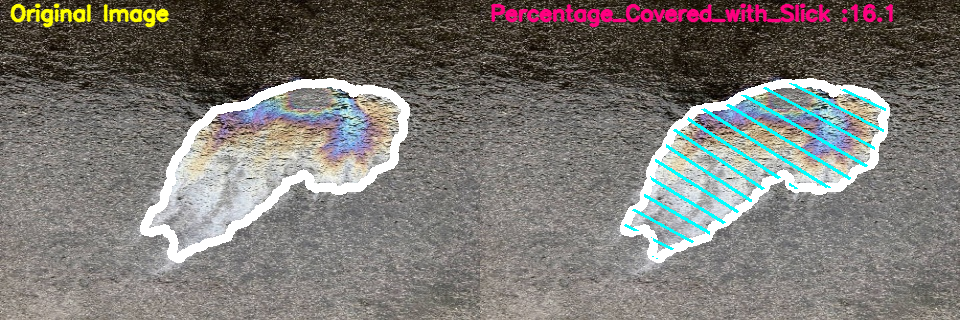

In [34]:
from PIL import Image
import os
count=0
ids = np.arange(len(test_dataset))


list = os.listdir("../Computer Vision/OSRL/Dataset/Dataset_Added/test/images/") # dir is your directory path
print(ids)
from google.colab.patches import cv2_imshow
for i in ids:
  
  if count<20:
    count=count+1
    image, gt_mask = test_dataset[i]

    width,height,n=image.shape

    kernel = np.ones((3,3), np.uint8) 
    img_dilation = cv2.dilate(image, kernel) 
    #cv2_imshow(img_dilation)

    boundmask = np.ones((320, 480, 3), dtype = "uint8")

    image = np.expand_dims(image, axis=0)
    #image_new = np.expand_dims(image, axis=0)
    image_new=np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    #img_dilation = cv2.dilate(pr_mask, kernel) 
    #print(pr_mask.shape)

    image=image.squeeze()
    image_new=image_new.squeeze()
    pr_mask=pr_mask[...,0].squeeze()
    


    print(pr_mask.shape)
    pr_mask = cv2.dilate(pr_mask, kernel,iterations=2)
    
    print(pr_mask.dtype)
    pr_mask = pr_mask.astype(np.uint8)

    # result=crosslines(pr_mask)
   
    # pr_mask=cv2.cvtColor(pr_mask, cv2.COLOR_BGR2GRAY);
    contours, hierarchy = cv2.findContours(pr_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(image, contours, -1, (255, 255, 255), 8)
    #cv2.drawContours(boundmask, contours, -1, (255, 0, 225), 8)
    #cv2_imshow(boundmask)
    im=crosslines(pr_mask,image)
    #cv2_imshow(im)

    RGB = np.zeros((width,height,3), dtype=np.uint8)
    RGB[pr_mask==1]=[0,255,0]
    RGB[pr_mask==0] = [0,0,0]

    res = cv2.add(image,RGB)
    #cv2_imshow(res)

    ###### Area Calculations ##############
    nzCount = cv2.countNonZero(pr_mask)
    print(nzCount)
    total_pixels=width*height
    print(total_pixels)
    covered_slick=(nzCount/total_pixels)*100
    print(covered_slick)
    area=str(round(covered_slick,2))
    ############################################
    # plt.imshow(img_dilation)
    # plt.show()

    image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    filename="res"+str(count)+".jpg"

    
    for j in range(image_new.shape[2]):
      #print(image[:,:,j].shape)
      image_new[:,:,j] = image_new[:,:,j] * pr_mask
    
    overlay_text = "Percentage_Covered_with_Slick :%s" % (area)
    
    cv2.putText(image, "Original Image", (height-470,width-300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
    #cv2.putText(image_new, overlay_text, (height-470,width-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2, cv2.LINE_AA)
    #numpy_horizontal_concat = np.concatenate((image, cv2.cvtColor(image_new, cv2.COLOR_RGB2BGR)), axis=1)
    cv2.putText(im, overlay_text, (height-470,width-300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 128), 2, cv2.LINE_AA)
    numpy_horizontal_concat = np.concatenate((image, cv2.cvtColor(im, cv2.COLOR_RGB2BGR)), axis=1)
    cv2_imshow(numpy_horizontal_concat)
    cv2.imwrite(os.path.join("../Computer Vision/OSRL/Dataset/Results_Unet_Model", filename),cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
   
   